In [19]:
import os
import sys

from datetime import datetime

import numpy as np
import polars as pl

from scipy.optimize import minimize

# Add project root to sys.path
sys.path.append(os.path.abspath(".."))

from src.utils.data_loader import load_retail_data, load_tgp_data

start_date = datetime(2009, 4, 1)
end_date = datetime(2012, 5, 31)

In [20]:
df_tgp = load_tgp_data(
    file_path="../data/113176-V1/data/TGP/tgpmin.csv",
    start_date=start_date,
    end_date=end_date,
).with_columns(pl.col("tgpmin").truediv(100).round(4))
df_ret = (
    load_retail_data(
        "../data/113176-V1/data/Prices", start_date=start_date, end_date=end_date
    )
    .rename(
        {"PUBLISH_DATE": "date", "BRAND_DESCRIPTION": "firm", "PRODUCT_PRICE": "price"}
    )
    .with_columns(pl.col("price").truediv(100).round(4))
    # .select(["date", "firm", "price"])
    # .filter(
    #    pl.col("firm").is_in(["BP", "Caltex", "Coles Express", "Caltex Woolworths"])
    # )
)

In [21]:
df_ret.describe()

statistic,date,TRADING_NAME,firm,PRODUCT_DESCRIPTION,price,ADDRESS,LOCATION,POSTCODE,,AREA_DESCRIPTION,REGION_DESCRIPTION
str,str,str,str,str,f64,str,str,f64,str,str,str
"""count""","""339740""","""339740""","""339740""","""339740""",339740.0,"""339740""","""339740""",339740.0,"""0""","""8970""","""8970"""
"""null_count""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""",0.0,"""339740""","""330770""","""330770"""
"""mean""","""2010-11-02 05:43:51.070000""",null,null,null,1.314324,null,null,6085.676176,null,null,null
"""std""",null,null,null,null,0.121314,null,null,54.265556,null,null,null
"""min""","""2009-04-01""","""Ampol Doubleview""","""Ampol""","""ULP""",1.048,"""1 Broadway (Cnr Stirling Hwy)""","""ALEXANDER HEIGHTS""",6000.0,null,"""East/Hills""","""Metro"""
"""25%""","""2010-01-18""",null,null,null,1.219,null,null,6030.0,null,null,null
"""50%""","""2010-11-03""",null,null,null,1.299,null,null,6076.0,null,null,null
"""75%""","""2011-08-18""",null,null,null,1.417,null,null,6147.0,null,null,null
"""max""","""2012-05-31""","""Yanchep Service Station""","""Wesco""","""ULP""",1.88,"""Whitfords City Shopping Centre…","""YOKINE""",6180.0,null,"""South of River""","""Peel"""


In [22]:
df_tgp.describe()

statistic,date,tgpmin
str,str,f64
"""count""","""1157""",1157.0
"""null_count""","""0""",0.0
"""mean""","""2010-10-31 00:00:00""",1.231995
"""std""",null,0.095277
"""min""","""2009-04-01""",1.058
"""25%""","""2010-01-15""",1.154
"""50%""","""2010-10-31""",1.202
"""75%""","""2011-08-16""",1.321
"""max""","""2012-05-31""",1.441


## Calibrating parameters

In [23]:
import polars as pl
from typing import Dict, Tuple

In [24]:
major_firms = ["BP", "Caltex", "Coles Express", "Caltex Woolworths"]

In [25]:
def calibrate_demand_parameters(
    df_ret: pl.DataFrame,
    df_tgp: pl.DataFrame,
    major_firms: list = ["BP", "Caltex", "Coles Express", "Caltex Woolworths"],
    alpha: float = 1,  # Price scaling parameter
    beta: float = 1.0,  # Quantity scaling parameter
) -> Dict[str, float]:
    """
    Calibrate ai (brand preferences) and μ (substitutability) parameters
    using Perth market data to match observed market shares and markups.
    """

    # Step 1: Calculate market shares by firm (using station-day observations as proxy)
    market_shares = (
        df_ret.filter(pl.col("firm").is_in(major_firms))
        .group_by("firm")
        .agg(pl.len().alias("station_days"))
        .with_columns(
            (pl.col("station_days") / pl.col("station_days").sum()).alias(
                "market_share"
            )
        )
        .select(["firm", "market_share"])
        .to_dict(as_series=False)
    )

    share_dict = dict(zip(market_shares["firm"], market_shares["market_share"]))
    # {
    #     "BP": 0.22,
    #     "Caltex": 0.16,
    #     "Coles Express": 0.16,
    #     "Caltex Woolworths": 0.14,
    # }
    print("Observed market shares:", share_dict)

    # Step 2: Calculate average prices and margins by firm
    firm_stats = (
        df_ret.filter(pl.col("firm").is_in(major_firms))
        .join(df_tgp, on="date", how="inner")
        .group_by("firm")
        .agg(
            [
                pl.col("price").mean().alias("avg_price"),
                (pl.col("price") - pl.col("tgpmin")).mean().alias("avg_margin"),
                pl.len().alias("n_obs"),
            ]
        )
    )

    print("Firm statistics:")
    print(firm_stats)

    # Convert to dictionaries for optimization
    avg_prices = dict(zip(firm_stats["firm"], firm_stats["avg_price"]))
    avg_margins = dict(zip(firm_stats["firm"], firm_stats["avg_margin"]))

    # Step 3: Set up optimization
    baseline_firm = "Caltex Woolworths"  # Set as baseline
    baseline_a = 2

    def calculate_logit_shares(
        prices: Dict[str, float],
        preferences: Dict[str, float],
        mu: float,
        alpha: float,
        beta: float,
        a0: float = 0,
    ) -> Dict[str, float]:
        """Calculate market shares using logit demand formula"""

        # Calculate utilities
        utilities = {}
        for firm in major_firms:
            utilities[firm] = (preferences[firm] - prices[firm]) / mu

        # Calculate denominator (including outside option)
        exp_utilities = {firm: np.exp(u) for firm, u in utilities.items()}
        denominator = sum(exp_utilities.values()) + np.exp(a0 / mu)

        # Calculate market shares
        shares = {}
        for firm in major_firms:
            shares[firm] = beta * exp_utilities[firm] / denominator

        return shares

    def calculate_optimal_markups(
        shares: Dict[str, float], mu: float
    ) -> Dict[str, float]:
        """Calculate optimal markups using first-order conditions"""
        markups = {}
        for firm in major_firms:
            # Lerner index = μ / (1 - s_i) where s_i is market share
            if shares[firm] < 0.99:  # Avoid division by zero
                markups[firm] = mu / (1 - shares[firm])
            else:
                markups[firm] = mu / 0.01  # Cap at very high markup
        return markups

    def objective(params: np.ndarray) -> float:
        """Objective function: minimize deviations from observed shares and markups"""

        # Unpack parameters
        mu = params[0]

        # Set up preferences dictionary
        preferences = {baseline_firm: baseline_a}
        param_idx = 1
        for firm in major_firms:
            if firm != baseline_firm:
                preferences[firm] = params[param_idx]
                param_idx += 1

        try:
            # Calculate predicted market shares
            pred_shares = calculate_logit_shares(
                avg_prices, preferences, mu, alpha, beta
            )

            # Calculate predicted markups (in same units as observed margins)
            pred_markups_lerner = calculate_optimal_markups(pred_shares, mu)
            pred_markups = {
                firm: markup * avg_prices[firm]
                for firm, markup in pred_markups_lerner.items()
            }

            # Calculate losses
            share_loss = sum(
                (pred_shares[firm] - share_dict[firm]) ** 2 for firm in major_firms
            )
            markup_loss = sum(
                (pred_markups[firm] - avg_margins[firm]) ** 2 for firm in major_firms
            )

            # Weight the losses (markup matching is typically more important)
            total_loss = share_loss + 0.1 * markup_loss

            return total_loss

        except (ValueError, ZeroDivisionError, OverflowError):
            return 1e6  # Return large penalty for invalid parameters

    # Step 4: Optimize parameters
    n_other_firms = len(major_firms) - 1  # Exclude baseline firm

    # Initial guess: μ=0.25, other firms slightly different from baseline
    initial_guess = [0.25] + [baseline_a + 0.1 * i for i in range(n_other_firms)]

    # Bounds: μ ∈ [0.1, 0.5], ai ∈ [1.5, 2.5]
    bounds = [(0.01, 1)] + [(0, 10)] * n_other_firms

    print("Starting optimization...")
    result = minimize(objective, initial_guess, method="L-BFGS-B", bounds=bounds)

    if not result.success:
        print(f"Optimization warning: {result.message}")

    # Step 5: Extract and return results
    mu_calibrated = result.x[0]

    preferences_calibrated = {baseline_firm: baseline_a}
    param_idx = 1
    for firm in major_firms:
        if firm != baseline_firm:
            preferences_calibrated[firm] = result.x[param_idx]
            param_idx += 1

    # Validate results
    final_shares = calculate_logit_shares(
        avg_prices, preferences_calibrated, mu_calibrated, alpha, beta
    )
    final_markups_lerner = calculate_optimal_markups(final_shares, mu_calibrated)
    final_markups = {
        firm: markup * avg_prices[firm] for firm, markup in final_markups_lerner.items()
    }

    print("\n=== Calibration Results ===")
    print(f"μ (substitutability): {mu_calibrated:.3f}")
    print("Brand preferences (ai):")
    for firm in major_firms:
        print(f"  {firm}: {preferences_calibrated[firm]:.3f}")

    print("\nValidation:")
    df_val = pl.DataFrame(
        {
            "Firm": major_firms,
            "Observed Share": [share_dict[firm] for firm in major_firms],
            "Predicted Share": [final_shares[firm] for firm in major_firms],
            "Observed Margin": [avg_margins[firm] for firm in major_firms],
            "Predicted Margin": [final_markups[firm] for firm in major_firms],
        }
    )

    print(df_val)

    # Return all calibrated parameters
    calibrated_params = {
        "mu": mu_calibrated,
        "alpha": alpha,
        "beta": beta,
        "a0": 0.0,  # Outside option
        **{f"a_{firm}": preferences_calibrated[firm] for firm in major_firms},
    }

    return calibrated_params

In [26]:
def create_demand_function(params: Dict[str, float], major_firms: list):
    """
    Create a demand function using calibrated parameters
    """

    def demand_function(
        prices: Dict[str, float], marginal_costs: Dict[str, float]
    ) -> Dict[str, Dict[str, float]]:
        """
        Calculate quantities and profits for given prices and costs

        Returns:
            Dict with 'quantities' and 'profits' for each firm
        """
        mu = params["mu"]
        alpha = params["alpha"]
        beta = 2.5  # params["beta"]
        a0 = params["a0"]

        # Calculate utilities
        utilities = {}
        for firm in major_firms:
            a_firm = params[f"a_{firm}"]
            utilities[firm] = (a_firm - prices[firm]) / mu

        # Calculate market shares
        exp_utilities = {firm: np.exp(u) for firm, u in utilities.items()}
        denominator = sum(exp_utilities.values()) + np.exp(a0 / mu)

        quantities = {}
        profits = {}

        for firm in major_firms:
            quantities[firm] = beta * exp_utilities[firm] / denominator
            profits[firm] = (prices[firm] - marginal_costs[firm]) * quantities[firm]

        return {"quantities": quantities, "profits": profits}

    return demand_function

In [27]:
# Assuming df_ret and df_tgp are already loaded
params = calibrate_demand_parameters(df_ret, df_tgp)

Observed market shares: {'BP': 0.32023915643004675, 'Caltex Woolworths': 0.2108533536253941, 'Coles Express': 0.24345689748885752, 'Caltex': 0.22545059245570173}
Firm statistics:
shape: (4, 4)
┌───────────────────┬───────────┬────────────┬───────┐
│ firm              ┆ avg_price ┆ avg_margin ┆ n_obs │
│ ---               ┆ ---       ┆ ---        ┆ ---   │
│ str               ┆ f64       ┆ f64        ┆ u32   │
╞═══════════════════╪═══════════╪════════════╪═══════╡
│ BP                ┆ 1.326397  ┆ 0.094374   ┆ 73647 │
│ Caltex            ┆ 1.314256  ┆ 0.07851    ┆ 51848 │
│ Coles Express     ┆ 1.307751  ┆ 0.075492   ┆ 55989 │
│ Caltex Woolworths ┆ 1.306968  ┆ 0.073269   ┆ 48491 │
└───────────────────┴───────────┴────────────┴───────┘
Starting optimization...

=== Calibration Results ===
μ (substitutability): 0.046
Brand preferences (ai):
  BP: 2.039
  Caltex: 2.010
  Coles Express: 2.007
  Caltex Woolworths: 2.000

Validation:
shape: (4, 5)
┌───────────────────┬────────────────┬────────

In [41]:
# Create demand function for LLM agents
major_firms = ["BP", "Caltex", "Coles Express", "Caltex Woolworths"]
demand_func = create_demand_function(params, major_firms)

# Test the demand function
test_prices = {
    "BP": 1.23,
    "Caltex": 1.16,
    "Coles Express": 1.16,
    "Caltex Woolworths": 1.11,
}
test_costs = {
    "BP": 1.107,
    "Caltex": 1.107,
    "Coles Express": 1.107,
    "Caltex Woolworths": 1.107,
}  # Will be replaced with TGP

results = demand_func(test_prices, test_costs)
print("\nTest demand function:")
print("Quantities:", results["quantities"])
print("Profits:", results["profits"])


Test demand function:
Quantities: {'BP': np.float64(0.2132687576675484), 'Caltex': np.float64(0.530434873523253), 'Coles Express': np.float64(0.4969144745499703), 'Caltex Woolworths': np.float64(1.2593818896057043)}
Profits: {'BP': np.float64(0.026232057193108452), 'Caltex': np.float64(0.028113048296732376), 'Coles Express': np.float64(0.026336467151148395), 'Caltex Woolworths': np.float64(0.003778145668817256)}


## Applying the model to the data

In [29]:
# Polars demand function
def apply_demand_function_vectorized(df: pl.DataFrame, demand_func) -> pl.DataFrame:
    """
    More efficient vectorized approach using pivot and join operations.
    """

    # Get unique dates
    dates = df["date"].unique().sort()

    results_list = []

    for date in dates:
        # Get data for this date
        date_data = df.filter(pl.col("date") == date)

        # Convert to dictionaries
        prices = dict(zip(date_data["firm"], date_data["price"]))
        marginal_costs = dict(zip(date_data["firm"], date_data["tgpmin"]))

        try:
            # Apply demand function
            results = demand_func(prices, marginal_costs)

            # Create result dataframe for this date
            date_results = pl.DataFrame(
                {
                    "date": [date] * len(results["quantities"]),
                    "firm": list(results["quantities"].keys()),
                    "quantity": list(results["quantities"].values()),
                    "profit": list(results["profits"].values()),
                }
            )

            results_list.append(date_results)

        except Exception:
            # Handle errors by creating zero results
            date_results = pl.DataFrame(
                {
                    "date": [date] * len(date_data),
                    "firm": date_data["firm"].to_list(),
                    "quantity": [0.0] * len(date_data),
                    "profit": [0.0] * len(date_data),
                }
            )
            results_list.append(date_results)

    # Combine all results
    all_results = pl.concat(results_list).with_columns(pl.col("profit").round(4))

    # Join back with original dataframe
    final_df = df.join(all_results, on=["date", "firm"], how="left")

    return final_df

In [30]:
df = (
    df_ret.select(["date", "firm", "price"])
    .filter(
        pl.col("firm").is_in(["BP", "Caltex", "Coles Express", "Caltex Woolworths"])
        & pl.col("date").is_between(datetime(2009, 4, 1), datetime(2012, 5, 1))
    )
    .group_by(["date", "firm"], maintain_order=True)
    .agg(pl.col("price").mean())
    .join(df_tgp, how="inner", on="date")
    .with_columns(
        pl.col("price").sub(pl.col("tgpmin")).round(4).alias("real_profit"),
        pl.int_range(pl.len()).over(["firm"]).alias("counter"),
    )
)

df = apply_demand_function_vectorized(
    df, demand_func=create_demand_function(params, major_firms=major_firms)
)

In [31]:
df[["profit", "real_profit"]].corr()

profit,real_profit
f64,f64
1.0,0.7459
0.7459,1.0


## Plotting

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

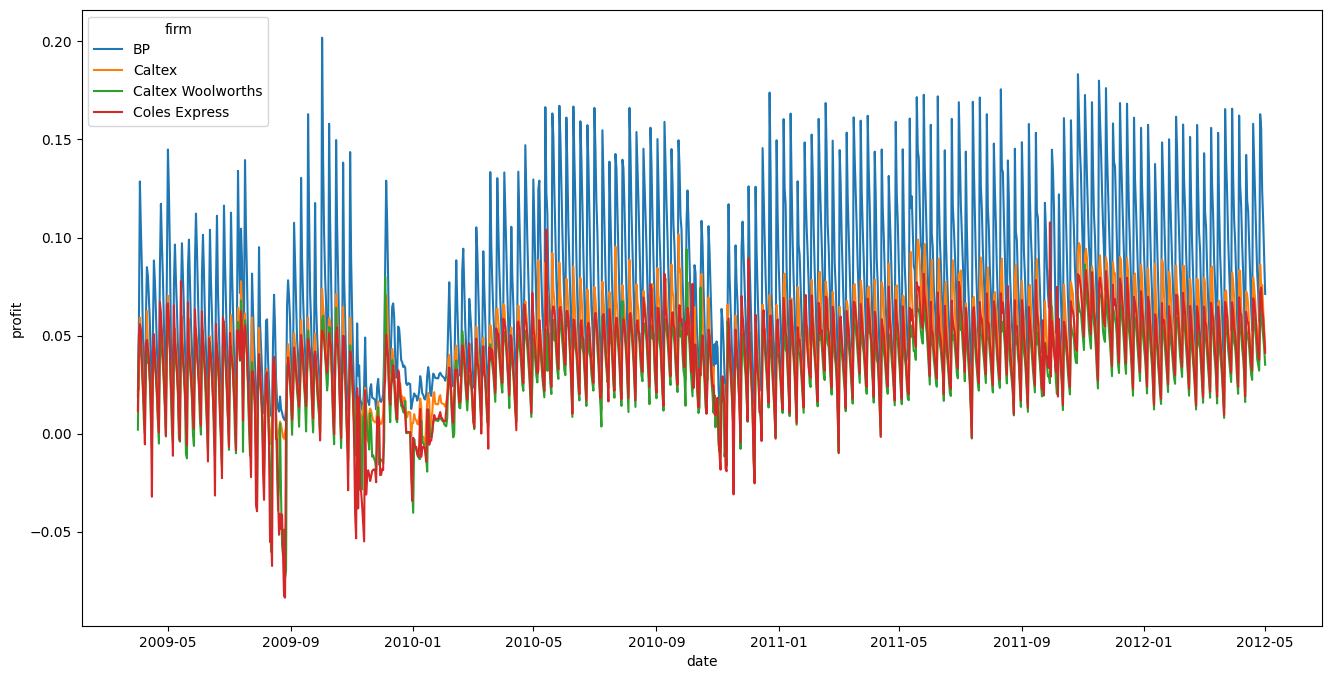

In [33]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df,
    x="date",
    y="profit",
    hue="firm",
)
plt.show()

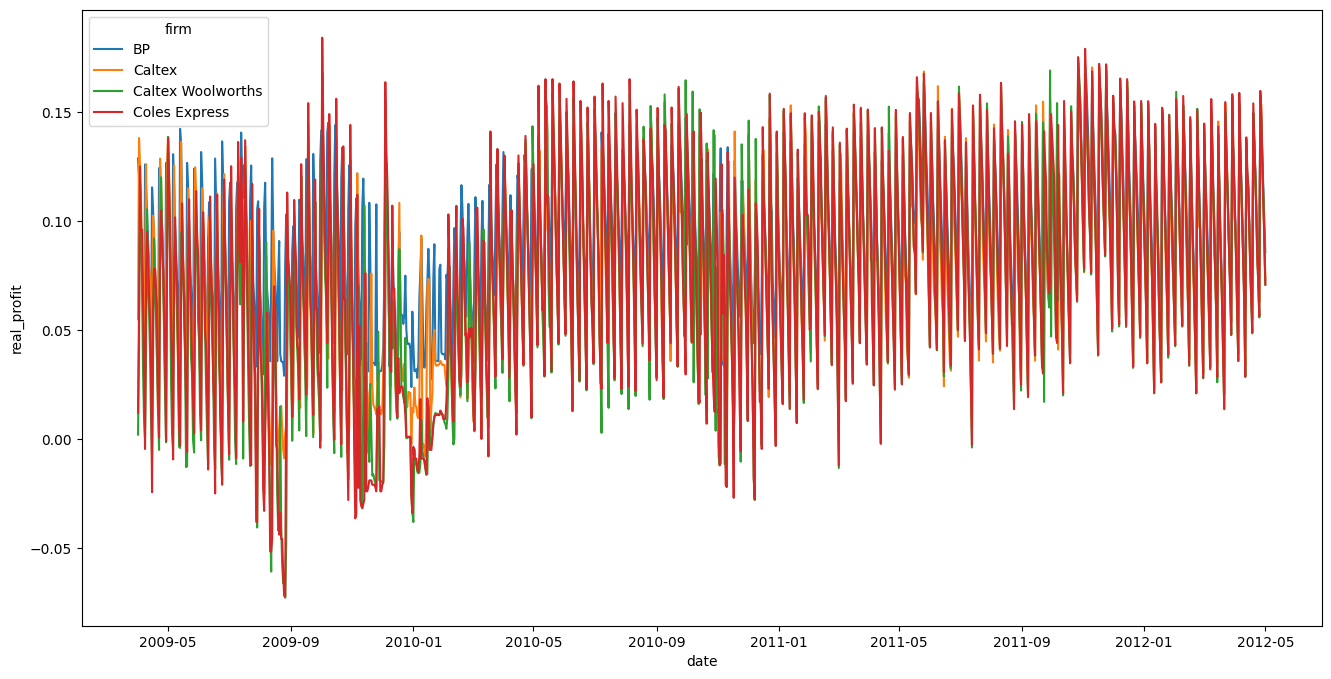

In [34]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df,
    x="date",
    y="real_profit",
    hue="firm",
)
plt.show()

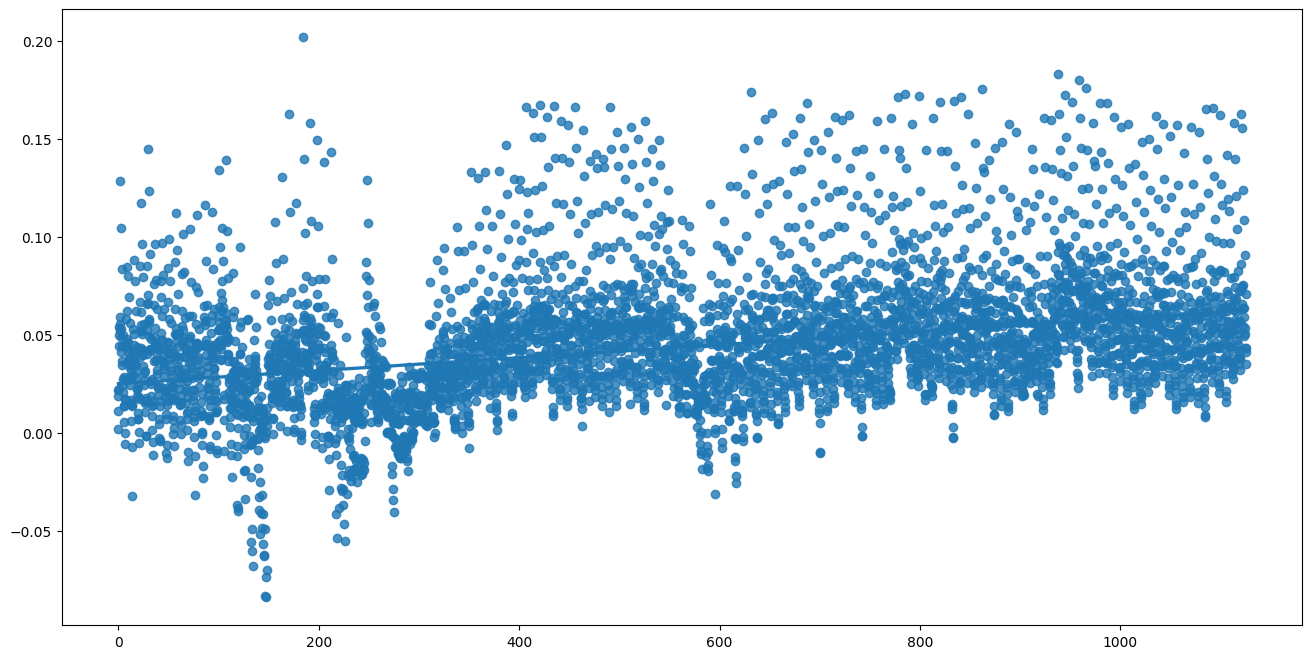

In [35]:
plt.figure(figsize=(16, 8))
sns.regplot(
    data=df,
    x="counter",
    y="profit",
    robust=True,
)
plt.show()

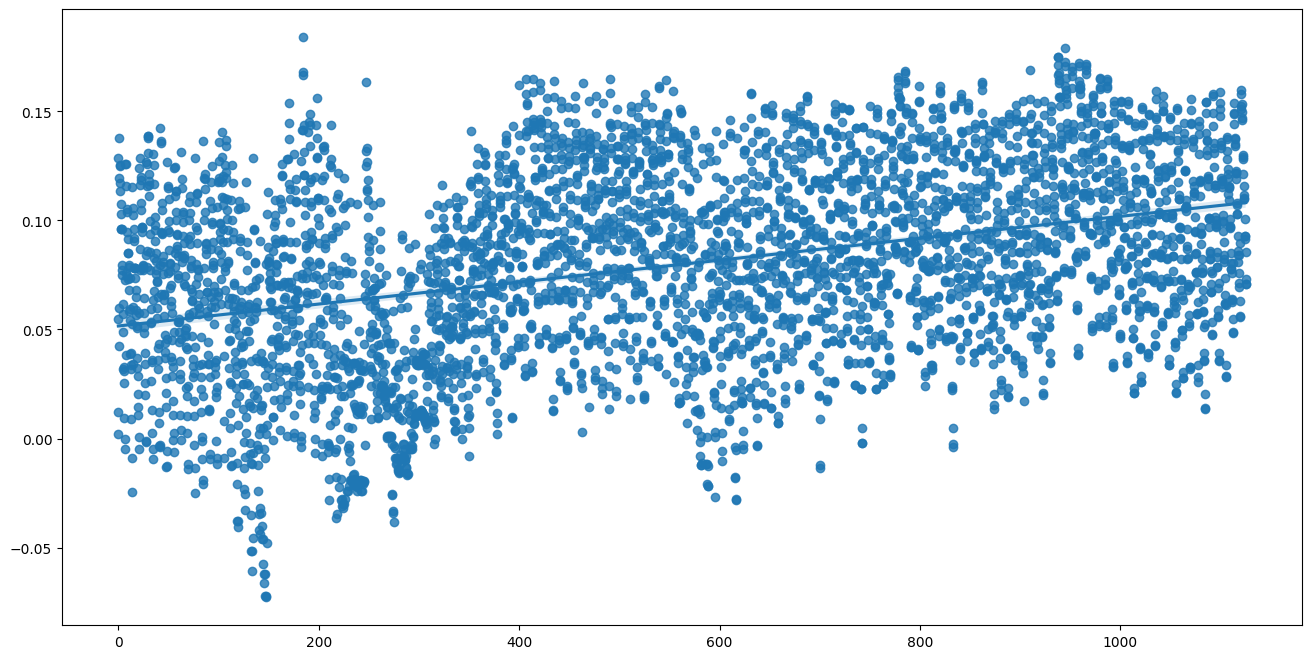

In [36]:
plt.figure(figsize=(16, 8))
sns.regplot(
    data=df,
    x="counter",
    y="real_profit",
    robust=True,
)
plt.show()

## Sensitivity analysis

In [46]:
# %%
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List


def calculate_elasticities(
    demand_func,
    prices: Dict[str, float],
    marginal_costs: Dict[str, float],
    major_firms: List[str],
    epsilon: float = 0.01,
) -> Dict[str, Dict[str, float]]:
    """Calculate own-price and cross-price elasticities"""

    # Base quantities
    base_results = demand_func(prices, marginal_costs)
    base_quantities = base_results["quantities"]

    elasticities = {}

    for firm_i in major_firms:
        elasticities[firm_i] = {}

        for firm_j in major_firms:
            # Increase firm j's price by epsilon
            test_prices = prices.copy()
            test_prices[firm_j] = prices[firm_j] * (1 + epsilon)

            # Calculate new quantities
            new_results = demand_func(test_prices, marginal_costs)
            new_quantities = new_results["quantities"]

            # Calculate elasticity: (% change in qi) / (% change in pj)
            if base_quantities[firm_i] > 0:
                percent_change_q = (
                    new_quantities[firm_i] - base_quantities[firm_i]
                ) / base_quantities[firm_i]
                percent_change_p = epsilon
                elasticity = percent_change_q / percent_change_p
            else:
                elasticity = 0

            elasticities[firm_i][firm_j] = elasticity

    return elasticities


def sensitivity_check_parameters(
    params: Dict[str, float],
    major_firms: List[str],
    test_prices: Dict[str, float],
    test_costs: Dict[str, float],
    param_ranges: Dict[str, Tuple[float, float]] = None,
) -> Dict[str, pl.DataFrame]:
    """Test sensitivity to parameter changes"""

    if param_ranges is None:
        param_ranges = {"mu": (0.1, 0.5), "beta": (1.0, 4.0)}

    sensitivity_results = {}

    for param_name, (min_val, max_val) in param_ranges.items():
        if param_name not in params:
            continue

        # Test range of values
        test_values = np.linspace(min_val, max_val, 10)
        results = []

        for test_val in test_values:
            # Create modified parameters
            test_params = params.copy()
            test_params[param_name] = test_val

            # Create demand function with modified parameters
            test_demand_func = create_demand_function(test_params, major_firms)

            try:
                # Calculate results
                demand_results = test_demand_func(test_prices, test_costs)

                for firm in major_firms:
                    results.append(
                        {
                            "parameter": param_name,
                            "value": test_val,
                            "firm": firm,
                            "quantity": demand_results["quantities"][firm],
                            "profit": demand_results["profits"][firm],
                        }
                    )
            except:
                # Handle errors
                for firm in major_firms:
                    results.append(
                        {
                            "parameter": param_name,
                            "value": test_val,
                            "firm": firm,
                            "quantity": 0,
                            "profit": 0,
                        }
                    )

        sensitivity_results[param_name] = pl.DataFrame(results)

    return sensitivity_results


def test_extreme_scenarios(
    demand_func,
    base_prices: Dict[str, float],
    base_costs: Dict[str, float],
    major_firms: List[str],
) -> Dict[str, Dict]:
    """Test demand function under extreme price scenarios"""

    scenarios = {}

    # Scenario 1: Very high prices (2x base)
    high_prices = {firm: price * 2 for firm, price in base_prices.items()}
    scenarios["high_prices"] = demand_func(high_prices, base_costs)

    # Scenario 2: Very low prices (0.5x base)
    low_prices = {firm: price * 0.5 for firm, price in base_prices.items()}
    scenarios["low_prices"] = demand_func(low_prices, base_costs)

    # Scenario 3: One firm much cheaper
    monopoly_prices = base_prices.copy()
    monopoly_prices[major_firms[0]] = base_prices[major_firms[0]] * 0.7
    scenarios["price_leader"] = demand_func(monopoly_prices, base_costs)

    # Scenario 4: All firms same price
    avg_price = np.mean(list(base_prices.values()))
    uniform_prices = {firm: avg_price for firm in major_firms}
    scenarios["uniform_prices"] = demand_func(uniform_prices, base_costs)

    return scenarios


def validate_economic_intuition(
    elasticities: Dict[str, Dict[str, float]],
    scenarios: Dict[str, Dict],
    base_results: Dict[str, Dict],
    major_firms: List[str],
    beta: float = 2.5,  # Expected market size scaling factor
) -> Dict[str, bool]:
    """Check if results align with economic intuition"""

    checks = {}

    # Check 1: Own-price elasticities should be negative
    own_elasticities_negative = True
    for firm in major_firms:
        if elasticities[firm][firm] >= 0:
            own_elasticities_negative = False
    checks["own_price_elasticities_negative"] = own_elasticities_negative

    # Check 2: Cross-price elasticities should be positive (substitutes)
    cross_elasticities_positive = True
    for firm_i in major_firms:
        for firm_j in major_firms:
            if firm_i != firm_j and elasticities[firm_i][firm_j] <= 0:
                cross_elasticities_positive = False
    checks["cross_price_elasticities_positive"] = cross_elasticities_positive

    # Check 3: Lower prices should increase total market demand
    total_base_share = sum(base_results["quantities"].values())
    total_low_share = sum(scenarios["low_prices"]["quantities"].values())
    total_high_share = sum(scenarios["high_prices"]["quantities"].values())

    # Market should expand when all prices drop
    quantities_increase_with_lower_prices = total_low_share >= total_base_share
    checks["quantities_increase_with_lower_prices"] = (
        quantities_increase_with_lower_prices
    )

    # Check 4: Market shares should sum to reasonable total (accounting for beta scaling)
    reasonable_market_size = (
        0.1 * beta <= total_base_share <= 1.2 * beta
        and 0.1 * beta <= total_low_share <= 1.5 * beta
        and 0.01 * beta <= total_high_share <= 1.0 * beta
    )
    checks["reasonable_market_size"] = reasonable_market_size

    # Check 5: Own-price elasticities should be reasonable (not too extreme)
    own_elasticities = [abs(elasticities[firm][firm]) for firm in major_firms]
    reasonable_elasticities = all(0.5 <= e <= 50 for e in own_elasticities)
    checks["reasonable_elasticity_magnitudes"] = reasonable_elasticities

    return checks


def run_comprehensive_sensitivity_analysis(
    params: Dict[str, float], major_firms: List[str], df: pl.DataFrame
) -> Dict:
    """Run all sensitivity checks"""

    # Use average prices and costs from data
    avg_data = df.group_by("firm").agg(
        [
            pl.col("price").mean().alias("avg_price"),
            pl.col("tgpmin").mean().alias("avg_cost"),
        ]
    )

    test_prices = dict(zip(avg_data["firm"], avg_data["avg_price"]))
    test_costs = dict(zip(avg_data["firm"], avg_data["avg_cost"]))

    # Create demand function
    demand_func = create_demand_function(params, major_firms)

    print("=== SENSITIVITY ANALYSIS RESULTS ===\n")

    # 1. Calculate elasticities
    print("1. ELASTICITY ANALYSIS")
    elasticities = calculate_elasticities(
        demand_func, test_prices, test_costs, major_firms
    )

    elasticity_df = []
    for firm_i in major_firms:
        for firm_j in major_firms:
            elasticity_df.append(
                {
                    "demand_firm": firm_i,
                    "price_firm": firm_j,
                    "elasticity": elasticities[firm_i][firm_j],
                    "type": "own-price" if firm_i == firm_j else "cross-price",
                }
            )

    elasticity_df = pl.DataFrame(elasticity_df)
    print("Own-price elasticities (should be negative):")
    print(
        elasticity_df.filter(pl.col("type") == "own-price")[
            ["demand_firm", "elasticity"]
        ]
    )
    print("\nCross-price elasticities (should be positive):")
    print(elasticity_df.filter(pl.col("type") == "cross-price").head(8))

    # 2. Parameter sensitivity
    print("\n2. PARAMETER SENSITIVITY")
    param_sensitivity = sensitivity_check_parameters(
        params, major_firms, test_prices, test_costs
    )

    # 3. Extreme scenarios
    print("\n3. EXTREME SCENARIO TESTING")
    base_results = demand_func(test_prices, test_costs)
    scenarios = test_extreme_scenarios(
        demand_func, test_prices, test_costs, major_firms
    )

    scenario_df = []
    for scenario_name, results in scenarios.items():
        for firm in major_firms:
            scenario_df.append(
                {
                    "scenario": scenario_name,
                    "firm": firm,
                    "quantity": results["quantities"][firm],
                    "profit": results["profits"][firm],
                }
            )

    scenario_df = pl.DataFrame(scenario_df)
    print("Market shares under different scenarios:")
    print(
        scenario_df.group_by("scenario").agg(
            pl.col("quantity").sum().alias("total_market_share")
        )
    )

    # 4. Economic intuition checks
    print("\n4. ECONOMIC INTUITION VALIDATION")
    validation_results = validate_economic_intuition(
        elasticities, scenarios, base_results, major_firms, beta=params.get("beta", 2.5)
    )

    for check, passed in validation_results.items():
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"{check}: {status}")

    # 5. Summary statistics
    print("\n5. SUMMARY STATISTICS")
    own_elasticities = [elasticities[firm][firm] for firm in major_firms]
    print(
        f"Own-price elasticity range: {min(own_elasticities):.3f} to {max(own_elasticities):.3f}"
    )
    print(f"Average own-price elasticity: {np.mean(own_elasticities):.3f}")

    total_market_share = sum(base_results["quantities"].values())
    print(f"Total market share covered: {total_market_share:.3f}")

    return {
        "elasticities": elasticity_df,
        "parameter_sensitivity": param_sensitivity,
        "scenarios": scenario_df,
        "validation": validation_results,
        "base_results": base_results,
    }


# Run the comprehensive analysis
analysis_results = run_comprehensive_sensitivity_analysis(params, major_firms, df)

=== SENSITIVITY ANALYSIS RESULTS ===

1. ELASTICITY ANALYSIS
Own-price elasticities (should be negative):
shape: (4, 2)
┌───────────────────┬────────────┐
│ demand_firm       ┆ elasticity │
│ ---               ┆ ---        │
│ str               ┆ f64        │
╞═══════════════════╪════════════╡
│ BP                ┆ -18.785105 │
│ Caltex            ┆ -19.987699 │
│ Coles Express     ┆ -20.037066 │
│ Caltex Woolworths ┆ -20.523583 │
└───────────────────┴────────────┘

Cross-price elasticities (should be positive):
shape: (8, 4)
┌───────────────┬───────────────────┬────────────┬─────────────┐
│ demand_firm   ┆ price_firm        ┆ elasticity ┆ type        │
│ ---           ┆ ---               ┆ ---        ┆ ---         │
│ str           ┆ str               ┆ f64        ┆ str         │
╞═══════════════╪═══════════════════╪════════════╪═════════════╡
│ BP            ┆ Caltex            ┆ 6.363817   ┆ cross-price │
│ BP            ┆ Coles Express     ┆ 6.245923   ┆ cross-price │
│ BP         

=== SENSITIVITY ANALYSIS RESULTS ===

1. ELASTICITY ANALYSIS
Own-price elasticities (should be negative):
shape: (4, 2)
┌───────────────────┬────────────┐
│ demand_firm       ┆ elasticity │
│ ---               ┆ ---        │
│ str               ┆ f64        │
╞═══════════════════╪════════════╡
│ BP                ┆ -18.785105 │
│ Caltex            ┆ -19.987699 │
│ Coles Express     ┆ -20.037066 │
│ Caltex Woolworths ┆ -20.523583 │
└───────────────────┴────────────┘

Cross-price elasticities (should be positive):
shape: (8, 4)
┌───────────────┬───────────────────┬────────────┬─────────────┐
│ demand_firm   ┆ price_firm        ┆ elasticity ┆ type        │
│ ---           ┆ ---               ┆ ---        ┆ ---         │
│ str           ┆ str               ┆ f64        ┆ str         │
╞═══════════════╪═══════════════════╪════════════╪═════════════╡
│ BP            ┆ Caltex            ┆ 6.363817   ┆ cross-price │
│ BP            ┆ Coles Express     ┆ 6.245923   ┆ cross-price │
│ BP         

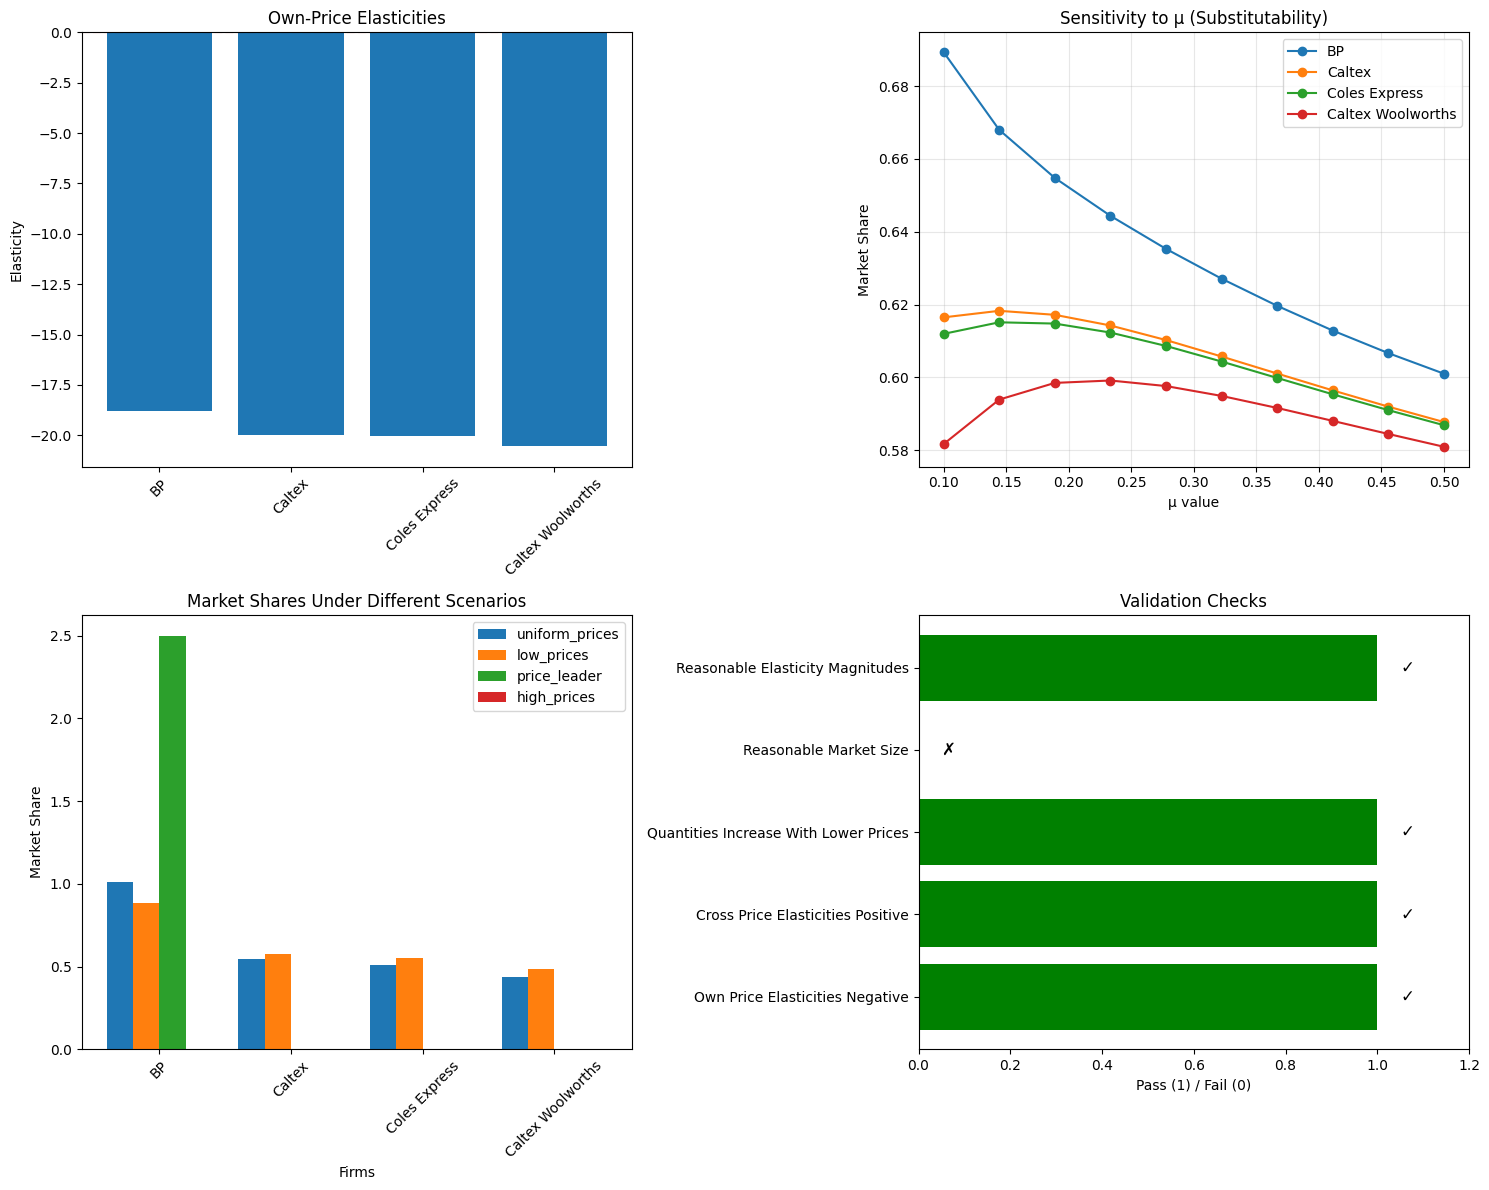

In [ ]:
# Plot parameter sensitivity
def plot_sensitivity_analysis(analysis_results):
    """Create visualizations for sensitivity analysis"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Own-price elasticities
    elasticity_data = analysis_results["elasticities"].filter(
        pl.col("type") == "own-price"
    )

    ax1 = axes[0, 0]
    bars = ax1.bar(elasticity_data["demand_firm"], elasticity_data["elasticity"])
    ax1.set_title("Own-Price Elasticities")
    ax1.set_ylabel("Elasticity")
    ax1.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    ax1.tick_params(axis="x", rotation=45)

    # Plot 2: Parameter sensitivity for mu
    if "mu" in analysis_results["parameter_sensitivity"]:
        mu_data = analysis_results["parameter_sensitivity"]["mu"]

        ax2 = axes[0, 1]
        for firm in major_firms:
            firm_data = mu_data.filter(pl.col("firm") == firm)
            ax2.plot(firm_data["value"], firm_data["quantity"], label=firm, marker="o")

        ax2.set_title("Sensitivity to μ (Substitutability)")
        ax2.set_xlabel("μ value")
        ax2.set_ylabel("Market Share")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Plot 3: Scenario comparison
    scenario_data = analysis_results["scenarios"]

    ax3 = axes[1, 0]
    scenarios = scenario_data["scenario"].unique()

    # Create grouped bar chart
    x = np.arange(len(major_firms))
    width = 0.2

    for i, scenario in enumerate(scenarios):
        scenario_subset = scenario_data.filter(pl.col("scenario") == scenario)
        quantities = [
            scenario_subset.filter(pl.col("firm") == firm)["quantity"][0]
            for firm in major_firms
        ]
        ax3.bar(x + i * width, quantities, width, label=scenario)

    ax3.set_title("Market Shares Under Different Scenarios")
    ax3.set_xlabel("Firms")
    ax3.set_ylabel("Market Share")
    ax3.set_xticks(x + width * (len(scenarios) - 1) / 2)
    ax3.set_xticklabels(major_firms, rotation=45)
    ax3.legend()

    # Plot 4: Validation summary
    ax4 = axes[1, 1]
    validation = analysis_results["validation"]

    checks = list(validation.keys())
    passed = [1 if validation[check] else 0 for check in checks]
    colors = ["green" if p else "red" for p in passed]

    bars = ax4.barh(range(len(checks)), passed, color=colors)
    ax4.set_yticks(range(len(checks)))
    ax4.set_yticklabels([check.replace("_", " ").title() for check in checks])
    ax4.set_xlabel("Pass (1) / Fail (0)")
    ax4.set_title("Validation Checks")
    ax4.set_xlim(0, 1.2)

    # Add text annotations
    for i, (bar, val) in enumerate(zip(bars, passed)):
        ax4.text(
            val + 0.05,
            i,
            "✓" if val else "✗",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()


# Run the plotting function
plot_sensitivity_analysis(analysis_results)